# Long Short-Term Memory (LSTM) networks

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) designed to model sequential data. They overcome the limitations of traditional RNNs by effectively capturing long-term dependencies in time-series or sequential data, making them ideal for tasks like speech recognition, language modeling, and time-series forecasting

In [1]:
# # Important Dependencies
# !pip install torch
# !pip install torch torchvision
# !pip install datasets
# !pip install transformers
# !pip install sentencepiece
# !pip install tqdm

# LSTM Cell Diagram

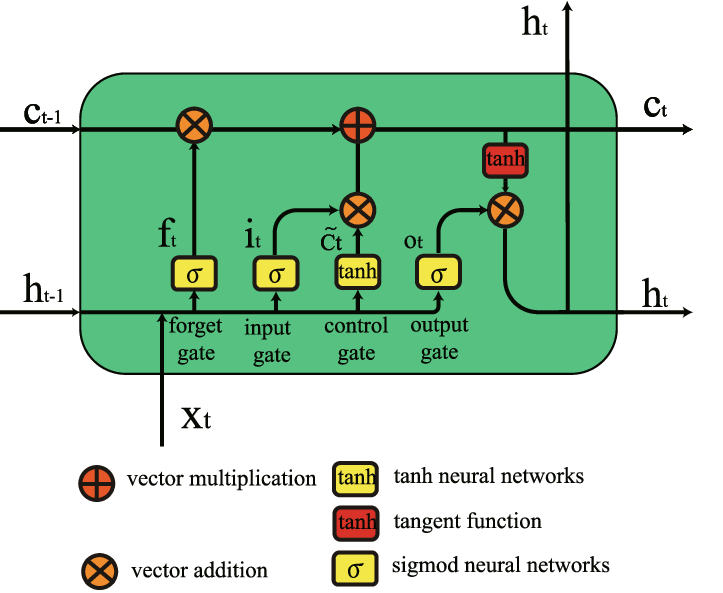

# LSTM Cell Architechture

In [2]:
import torch
import torch.nn as nn

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        # Input gate components
        self.W_ii = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_hi = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))
        
        # Forget gate components
        self.W_if = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_hf = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))
        
        # Cell gate components
        self.W_ig = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_hg = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_g = nn.Parameter(torch.Tensor(hidden_size))
        
        # Output gate components
        self.W_io = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_ho = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))
        
        self.init_weights()

    def init_weights(self):
        for param in self.parameters():
            nn.init.uniform_(param, -0.1, 0.1)
        
    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        i_t = torch.sigmoid(x @ self.W_ii.T + h_prev @ self.W_hi.T + self.b_i)
        f_t = torch.sigmoid(x @ self.W_if.T + h_prev @ self.W_hf.T + self.b_f)
        g_t = torch.tanh(x @ self.W_ig.T + h_prev @ self.W_hg.T + self.b_g) #control gate
        o_t = torch.sigmoid(x @ self.W_io.T + h_prev @ self.W_ho.T + self.b_o)
        
        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        
        return h_t, (h_t, c_t)

# LSTM Module


In [3]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_window_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size  # Size of the hidden state for each LSTM layer
        self.num_layers = num_layers  # Number of stacked LSTM layers
        
        # Create a list of LSTM Cell
        self.cells = nn.ModuleList([
            LSTMCell(input_window_size, hidden_size) if i == 0 
            else LSTMCell(hidden_size, hidden_size) 
            for i in range(num_layers)
        ])
        
        # Fully connected layer to map the hidden state to the desired output size
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """
        Forward pass for the LSTM model.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_window_size)
        
        Returns:
            outputs: Tensor of shape (batch_size, seq_len, hidden_size) containing the hidden states
        """
        batch_size, seq_len, _ = x.size()  # Extract batch size, sequence length, and input size
        
        # Initialize hidden and cell states for all layers with zeros
        # Shape for each: (batch_size, hidden_size)
        h = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        
        outputs = []  # List to store the hidden states of the last layer for each time step

        # Loop through each time step in the sequence
        for t in range(seq_len):
            x_t = x[:, t, :]  # Extract the input for the current time step, shape: (batch_size, input_window_size)
            
            # Pass the input through each LSTM layer sequentially
            for i, cell in enumerate(self.cells):
                # Update the hidden and cell states for the current layer
                h[i], (h[i], c[i]) = cell(x_t, (h[i], c[i]))
                
                # The output of the current layer becomes the input for the next layer
                x_t = h[i]
            
            # Append the hidden state of the last layer (h[-1]) for the current time step
            outputs.append(h[-1])

        # Stack the list of hidden states into a tensor of shape (batch_size, seq_len, hidden_size)
        outputs = torch.stack(outputs, dim=1)
        
        # Return the sequence of hidden states
        return outputs


# Dataset (Machine Translation)

We will be using the dataset https://huggingface.co/datasets/cfilt/iitb-english-hindi for english to hindi translation from hugging face

In [4]:
from datasets import load_dataset
from torch.utils.data import DataLoader, Subset
import torch
from transformers import AutoTokenizer

# Load the dataset
ds = load_dataset("cfilt/iitb-english-hindi")

ds

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1659083
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 520
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2507
    })
})

In [5]:
ds['train']

Dataset({
    features: ['translation'],
    num_rows: 1659083
})

In [6]:
ds['train'][0]

{'translation': {'en': 'Give your application an accessibility workout',
  'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}}

In [7]:
ds['train'][0]['translation']

{'en': 'Give your application an accessibility workout',
 'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}

# Tokenization Function

In [8]:
# Function to tokenize the dataset


# Load a pre-trained tokenizer for English to Hindi translation
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-hi")

def tokenize_function(batch):
    # Access the 'en' and 'hi' keys inside the 'translation' dictionary for all items in the batch
    en_sentences = [item['en'] for item in batch['translation']]
    hi_sentences = [item['hi'] for item in batch['translation']]
    
    # Tokenize the English sentences
    en_inputs = tokenizer(
        en_sentences, 
        padding="max_length", 
        truncation=True, 
        max_length=64
    )
    
    # Tokenize the Hindi sentences
    hi_labels = tokenizer(
        hi_sentences, 
        padding="max_length", 
        truncation=True, 
        max_length=64
    )
    
    # Return the combined dictionary
    return {
        'input_ids': en_inputs['input_ids'],
        'attention_mask': en_inputs['attention_mask'],
        'labels': hi_labels['input_ids']
    }

# Tokenize the dataset
tokenized_ds = ds.map(tokenize_function, batched=True, remove_columns=["translation"])

C:\Users\bibha\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


# Subset Function

A subset of main dataset (around 10%) is taken.

In [9]:
# Take only 10% of each split
def get_subset(dataset, percentage):
    subset_size = int(len(dataset) * percentage)
    return Subset(dataset, range(subset_size))

# Apply the 10% split
train_subset = get_subset(tokenized_ds['train'], 0.01)
val_subset = get_subset(tokenized_ds['validation'], 0.01)
test_subset = get_subset(tokenized_ds['test'], 0.01)

# Tensor Conversion from Batches

In [10]:
# This function is used to combine individual items in a batch into a single tensor
def collate_fn(batch):
    input_ids = torch.tensor([x['input_ids'] for x in batch], dtype=torch.long)
    attention_mask = torch.tensor([x['attention_mask'] for x in batch], dtype=torch.long)
    labels = torch.tensor([x['labels'] for x in batch], dtype=torch.long)
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
    }


# Dataloaders


In [11]:
# Create DataLoaders
train_dataloader = DataLoader(train_subset, batch_size=32, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(test_subset, batch_size=32, collate_fn=collate_fn)

In [12]:
# Example: Fetch a batch
for batch in train_dataloader:
    print(batch)
    break


{'input_ids': tensor([[    4,   371,     8,  ..., 61949, 61949, 61949],
        [   17, 19266,    13,  ..., 61949, 61949, 61949],
        [  611,     8,  2881,  ..., 61949, 61949, 61949],
        ...,
        [ 6207, 14092,     0,  ..., 61949, 61949, 61949],
        [12918,     0, 61949,  ..., 61949, 61949, 61949],
        [  238,  9906, 14186,  ..., 61949, 61949, 61949]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[   44,  1333,   549,  ..., 61949, 61949, 61949],
        [   17,   197,  1185,  ..., 61949, 61949, 61949],
        [   44,     1,  1543,  ..., 61949, 61949, 61949],
        ...,
        [   44, 11506,  2136,  ..., 61949, 61949, 61949],
        [   44,  5935,  1042,  ..., 61949, 61949, 61949],
        [  238, 14186,    44,  ..., 61949, 61949, 61949]])}


# Checking for GPU

In [13]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sequence to Sequence Architechture

It is a very famous architechture involving encoder and decoder block to solve sequence problems like machine translation

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt


class Seq2SeqLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(Seq2SeqLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Use your custom LSTM class for encoder and decoder
        self.encoder = LSTM(input_window_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = LSTM(input_window_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers)
        
        # Output layer to map LSTM outputs to vocab size
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, en_input, hi_input):
        # Embedding for inputs
        en_embedded = self.embedding(en_input)  # Shape: (batch_size, seq_len, embedding_dim)
        hi_embedded = self.embedding(hi_input)  # Shape: (batch_size, seq_len, embedding_dim)

        # Encode English sentence
        encoder_output = self.encoder(en_embedded)  # Encoder output shape: (batch_size, seq_len, hidden_size)

        # Initialize the hidden state and cell state for the decoder from the encoder
        hidden_state, cell_state = encoder_output[:, -1, :], encoder_output[:, -1, :]  # Use last hidden state and cell state

        # Decode using the encoder's hidden states
        decoder_output = self.decoder(hi_embedded)  # Decoder output shape: (batch_size, seq_len, hidden_size)

        # Project to vocabulary size
        output = self.fc_out(decoder_output)  # Shape: (batch_size, seq_len, vocab_size)

        return output

# Example usage
vocab_size = len(tokenizer)  # Vocabulary size
embedding_dim = 512  # Feature dimension of embedding
hidden_size = 512
num_layers = 2

model = Seq2SeqLSTM(vocab_size, embedding_dim, hidden_size, num_layers).to(device)


# Save the model state_dict (parameters)
torch.save(model.state_dict(), 'seq2seq_lstm.pth')


# Load the Model
# model = Seq2SeqLSTM(vocab_size, embedding_dim, hidden_size, num_layers).to(device)
# model.load_state_dict(torch.load('seq2seq_lstm.pth'))
# model.eval()


# Loss Function and Optimizer

In [15]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Set fewer epochs and reduce the dataset size for faster training
epochs = 2  # Reduced epochs
batch_size = 4  # Optionally reduce batch size for faster iterations

# Mixed Precision Training

Mixed precision training is used to speed up training and reduce memory usage

In [16]:
# Mixed Precision Scaler
scaler = torch.cuda.amp.GradScaler()  #scale gradients during backpropagation to avoid numerical instability

C:\Users\bibha\AppData\Local\Temp\ipykernel_16252\1487334734.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  #scale gradients during backpropagation to avoid numerical instability
C:\Users\bibha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


# Training

In [17]:
# Initialize lists to store losses for plotting
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    # Using tqdm to create a progress bar for the training loop
    with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
        for batch in pbar:
            en_input_ids = batch['input_ids'].to(device)  # Move to GPU
            hi_input_ids = batch['labels'].to(device)  # Move to GPU

            # Shift target sequence for decoding
            decoder_input_ids = hi_input_ids[:, :-1]  # All tokens except last
            decoder_target_ids = hi_input_ids[:, 1:]  # All tokens except first

            optimizer.zero_grad()

            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                output = model(en_input_ids, decoder_input_ids)
                loss = criterion(output.view(-1, vocab_size), decoder_target_ids.reshape(-1))

            # Backward pass with mixed precision
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item()

            # Update the progress bar with the current loss value
            pbar.set_postfix(loss=loss.item())

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}")

Epoch 1/2:   0%|                                                                            | 0/519 [00:00<?, ?batch/s]C:\Users\bibha\AppData\Local\Temp\ipykernel_16252\41442509.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\bibha\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/2: 100%|███████████████████████████████████████████████████████| 519/519 [29:15<00:00,  3.38s/batch, loss=1.66]


Epoch 1/2, Training Loss: 2.9094


Epoch 2/2: 100%|███████████████████████████████████████████████████████| 519/519 [32:37<00:00,  3.77s/batch, loss=1.35]

Epoch 2/2, Training Loss: 1.6106


# Testing

In [18]:
for epoch in range(epochs):
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            en_input_ids = batch['input_ids'].to(device)  # Move to GPU
            hi_input_ids = batch['labels'].to(device)  # Move to GPU

            # Shift target sequence for decoding
            decoder_input_ids = hi_input_ids[:, :-1]
            decoder_target_ids = hi_input_ids[:, 1:]

            with torch.cuda.amp.autocast():
                output = model(en_input_ids, decoder_input_ids)
                loss = criterion(output.view(-1, vocab_size), decoder_target_ids.reshape(-1))
                total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}/{epochs}, Test Loss: {avg_test_loss:.4f}")

C:\Users\bibha\AppData\Local\Temp\ipykernel_16252\3508721637.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/2, Test Loss: 3.0228
Epoch 2/2, Test Loss: 3.0228


# Plot of Training and Test loss vs Epochs

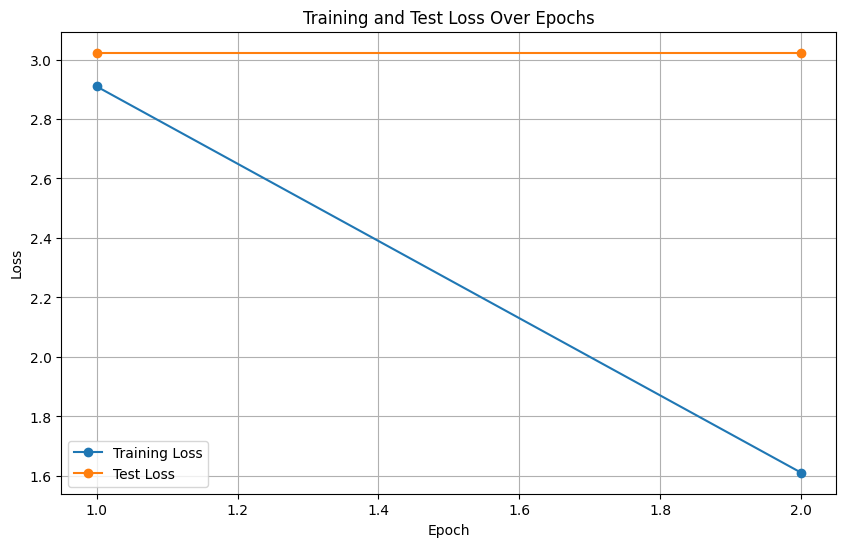

In [19]:
# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()


# Thank you
